In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from src.hiveconnect import hiveapp

In [2]:
data = hiveapp.ExtractRows('select * from fact_segment','buidu')

c:\Education\Uni\BigData\Final_Project\Data-Mining-with-ApacheHive\src\hiveconnect\hiveapp.py:182: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sqlstr, connection)



 converting the rows_data into python list of tuples 

converted suscessfully the rows_data into python list of tuples


In [ ]:
# data

In [4]:
df = pd.DataFrame(columns=['customer_id','city','country','active','full_name','rental_id','amount',
                           'rental_date','first_date','recency','monetary','frequency'])

for tup in tqdm(data):
    df.loc[len(df)] = list(tup)

100%|██████████| 16044/16044 [00:40<00:00, 395.66it/s]


In [5]:
fact_segment = df.copy()
fact_segment.head()

,customer_id,city,country,active,full_name,rental_id,amount,rental_date,first_date,recency,monetary,frequency
0,448,Erlangen,Germany,1,MIGUEL BETANCOURT,13250,3.99,2005-08-19,2005-05-26,264,135.70999,29
1,448,Erlangen,Germany,1,MIGUEL BETANCOURT,15358,9.99,2005-08-22,2005-05-26,264,135.70999,29
2,448,Erlangen,Germany,1,MIGUEL BETANCOURT,3992,6.99,2005-07-06,2005-05-26,264,135.70999,29
3,448,Erlangen,Germany,1,MIGUEL BETANCOURT,14711,2.99,2005-08-21,2005-05-26,264,135.70999,29
4,448,Erlangen,Germany,1,MIGUEL BETANCOURT,3347,5.99,2005-06-21,2005-05-26,264,135.70999,29


In [7]:
fact_segment.to_csv('./data/tables/factSegment.csv', index=False)

# fact_segment = pd.read_csv('./data/tables/factSegment.csv').drop(columns=['Unnamed: 0'], axis=1)
# fact_segment.head()

## **Khám phá dữ liệu được tổng hợp**

In [8]:
fact_segment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16044 entries, 0 to 16043
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  16044 non-null  int64  
 1   city         16044 non-null  object 
 2   country      16044 non-null  object 
 3   active       16044 non-null  int64  
 4   full_name    16044 non-null  object 
 5   rental_id    16044 non-null  int64  
 6   amount       16044 non-null  float64
 7   rental_date  16044 non-null  object 
 8   first_date   16044 non-null  object 
 9   recency      16044 non-null  int64  
 10  monetary     16044 non-null  float64
 11  frequency    16044 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 1.6+ MB


In [9]:
fact_segment.duplicated().sum()

0

In [10]:
fact_segment.isna().sum()

customer_id    0
city           0
country        0
active         0
full_name      0
rental_id      0
amount         0
rental_date    0
first_date     0
recency        0
monetary       0
frequency      0
dtype: int64

In [11]:
fact_segment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16044 entries, 0 to 16043
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  16044 non-null  int64  
 1   city         16044 non-null  object 
 2   country      16044 non-null  object 
 3   active       16044 non-null  int64  
 4   full_name    16044 non-null  object 
 5   rental_id    16044 non-null  int64  
 6   amount       16044 non-null  float64
 7   rental_date  16044 non-null  object 
 8   first_date   16044 non-null  object 
 9   recency      16044 non-null  int64  
 10  monetary     16044 non-null  float64
 11  frequency    16044 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 1.6+ MB


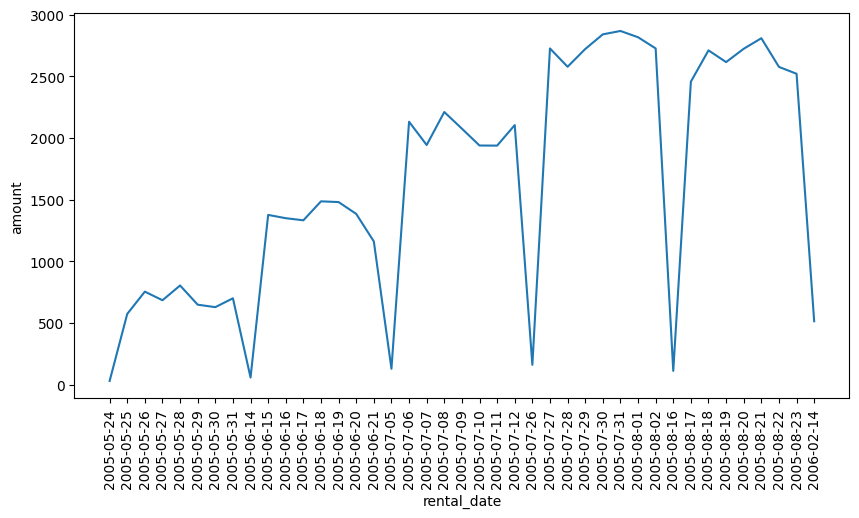

In [12]:
revenue_date = fact_segment.groupby('rental_date')['amount'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(x=revenue_date['rental_date'], y=revenue_date['amount'])
plt.xticks(rotation=90)
plt.show()

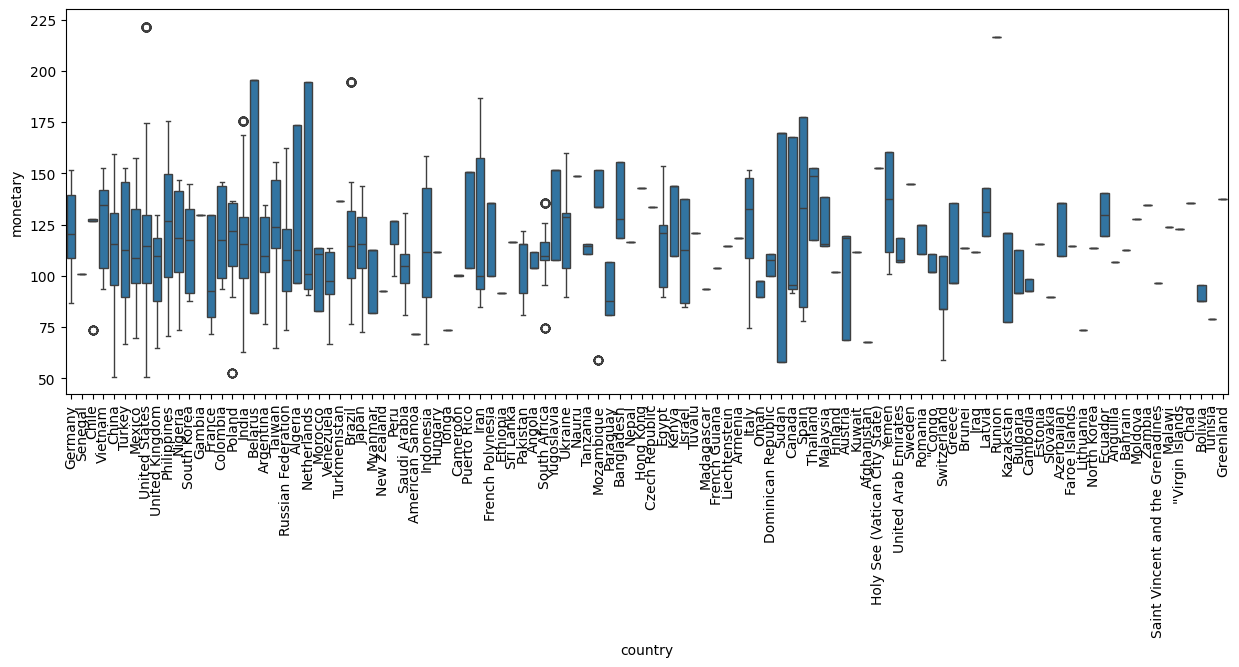

In [13]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=fact_segment, y='monetary', x='country', legend=False)
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='frequency', ylabel='recency'>

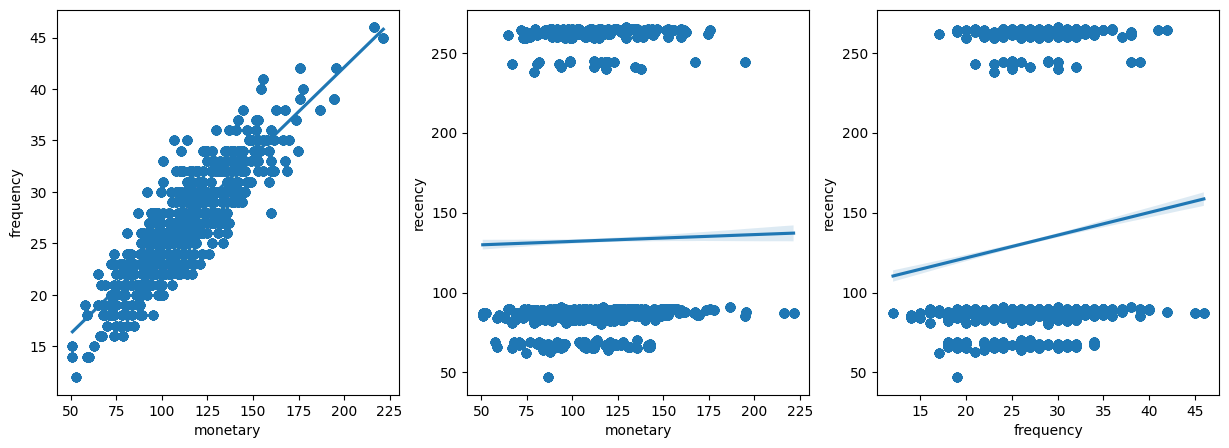

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.regplot(data=fact_segment, x='monetary', y='frequency', ax=ax[0])
sns.regplot(data=fact_segment, x='monetary', y='recency', ax=ax[1])
sns.regplot(data=fact_segment, x='frequency', y='recency', ax=ax[2])

## **Phân cụm khách hàng**

In [15]:
final_segment = fact_segment[['recency','monetary','frequency']]
final_segment = final_segment.drop_duplicates().reset_index().drop(columns=['index'])

scaler = MinMaxScaler().set_output(transform="pandas")
segment_scale = scaler.fit_transform(final_segment)
segment_scale

,recency,monetary,frequency
0,0.990868,0.497129,0.500000
1,0.196347,0.292326,0.382353
2,0.191781,0.134681,0.117647
3,0.995434,0.532220,0.529412
4,0.981735,0.291857,0.617647
...,...,...,...
573,0.191781,0.461922,0.529412
574,0.986301,0.654774,0.764706
575,0.164384,0.198770,0.294118
576,0.182648,0.251435,0.323529


* Find the optimal clusters for Kmeans

In [16]:
from clusteval import clusteval

In [17]:
# Set parameters, as an example dbscan
ce = clusteval(evaluate='silhouette')

# Fit to find optimal number of clusters using dbscan
results= ce.fit(segment_scale)

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 75.86it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


<Figure size 1000x500 with 0 Axes>

[clusteval] >DEBUG> findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0.
[clusteval] >DEBUG> findfont: score(FontEntry(fname='c:\\Education\\Uni\\BigData\\Final_Project\\Data-Mining-with-ApacheHive\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
[clusteval] >DEBUG> findfont: score(FontEntry(fname='c:\\Education\\Uni\\BigData\\Final_Project\\Data-Mining-with-ApacheHive\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[clusteval] >DEBUG> findfont: score(FontEntry(fname='c:\\Education\\Uni\\BigData\\Final_Project\\Data-Mining-with-ApacheHive\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymBol.ttf', name=

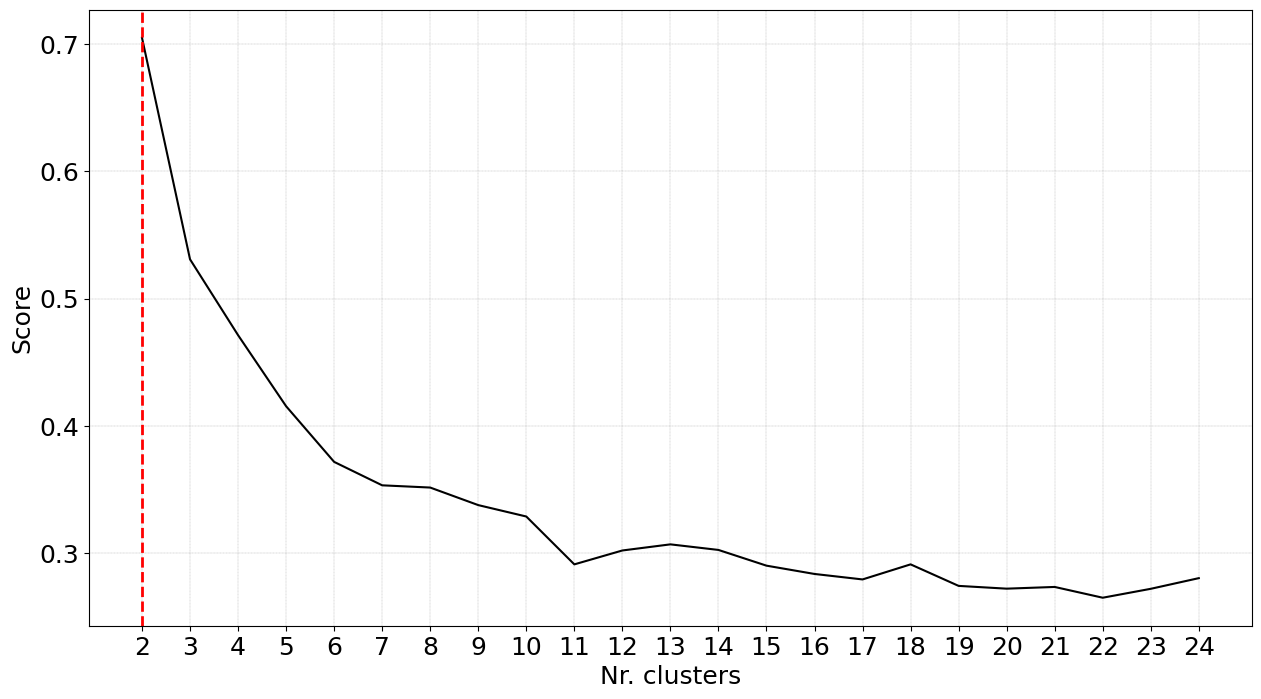

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [18]:
plt.figure(figsize=(10,5))
ce.plot()

* Implement clustering by approprate k clusters

In [22]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init='auto', verbose=0).fit(segment_scale)
segmentation = kmeans.predict(segment_scale)

In [23]:
kmeans.cluster_centers_

array([[0.17245201, 0.24708085, 0.31096516],
       [0.97349967, 0.35210688, 0.46323529],
       [0.1713795 , 0.44660788, 0.52752294],
       [0.15350238, 0.13095514, 0.17334168],
       [0.18835616, 0.83109259, 0.84558824],
       [0.98287671, 0.50393968, 0.57352941],
       [0.97031963, 0.2287887 , 0.32466063],
       [0.18760323, 0.58112032, 0.63454318],
       [0.97222222, 0.65774266, 0.74509804],
       [0.16935747, 0.34618222, 0.41780462]])

[clusteval] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[clusteval] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


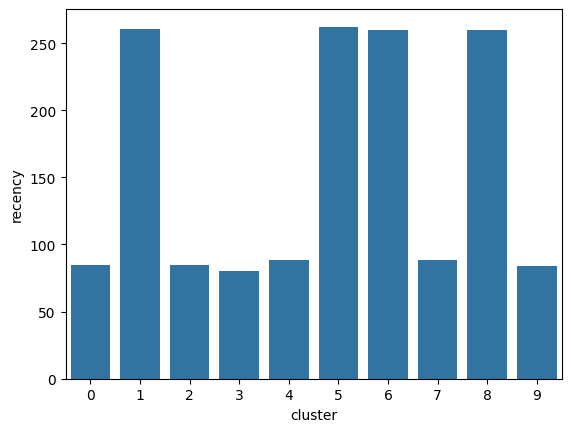

[clusteval] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[clusteval] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


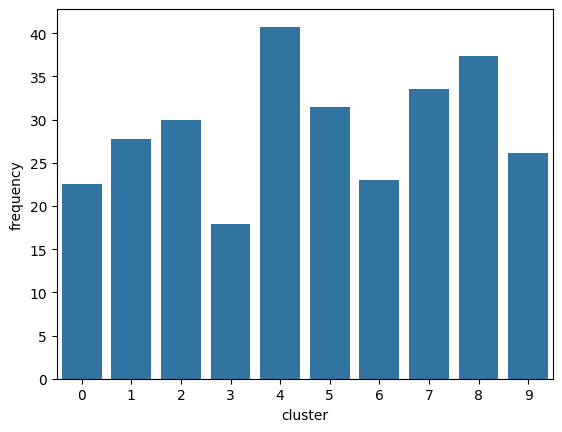

[clusteval] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[clusteval] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


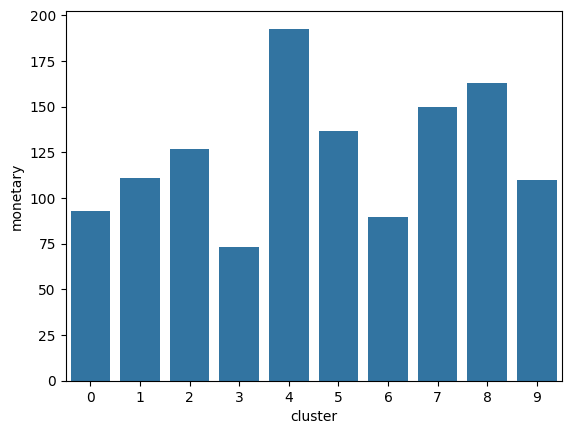

In [24]:
final_segment['cluster'] = segmentation
customer_clusters = final_segment.groupby(['cluster'], as_index=False).mean()

cols = ['recency','frequency','monetary']

for i in cols:
    sns.barplot(data=customer_clusters, x='cluster', y=i)
    plt.show()